In [1]:
!nvidia-smi

Sun Dec 15 12:33:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   49C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 900kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.1kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.97MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/16] | D Loss: 0.7579 | G Loss: 2.3294
Epoch [2/16] | D Loss: 0.7005 | G Loss: 1.4907
Epoch [3/16] | D Loss: 1.0147 | G Loss: 2.5650
Epoch [4/16] | D Loss: 0.7160 | G Loss: 2.2308
Epoch [5/16] | D Loss: 1.1762 | G Loss: 2.9792
Epoch [6/16] | D Loss: 0.7579 | G Loss: 1.8078
Epoch [7/16] | D Loss: 0.8258 | G Loss: 1.5767
Epoch [8/16] | D Loss: 0.8275 | G Loss: 1.3295
Epoch [9/16] | D Loss: 0.8226 | G Loss: 2.0519
Epoch [10/16] | D Loss: 0.7650 | G Loss: 1.9216
Epoch [11/16] | D Loss: 0.8190 | G Loss: 1.7065
Epoch [12/16] | D Loss: 0.7511 | G Loss: 1.6003
Epoch [13/16] | D Loss: 0.7692 | G Loss: 2.0903
Epoch [14/16] | D Loss: 0.7119 | G Loss: 2.4489
Epoch [15/16] | D Loss: 0.7125 | G Loss: 2.2948
Epoch [16/16] | D Loss: 0.7876 | G Loss: 1.8297
Training complete!


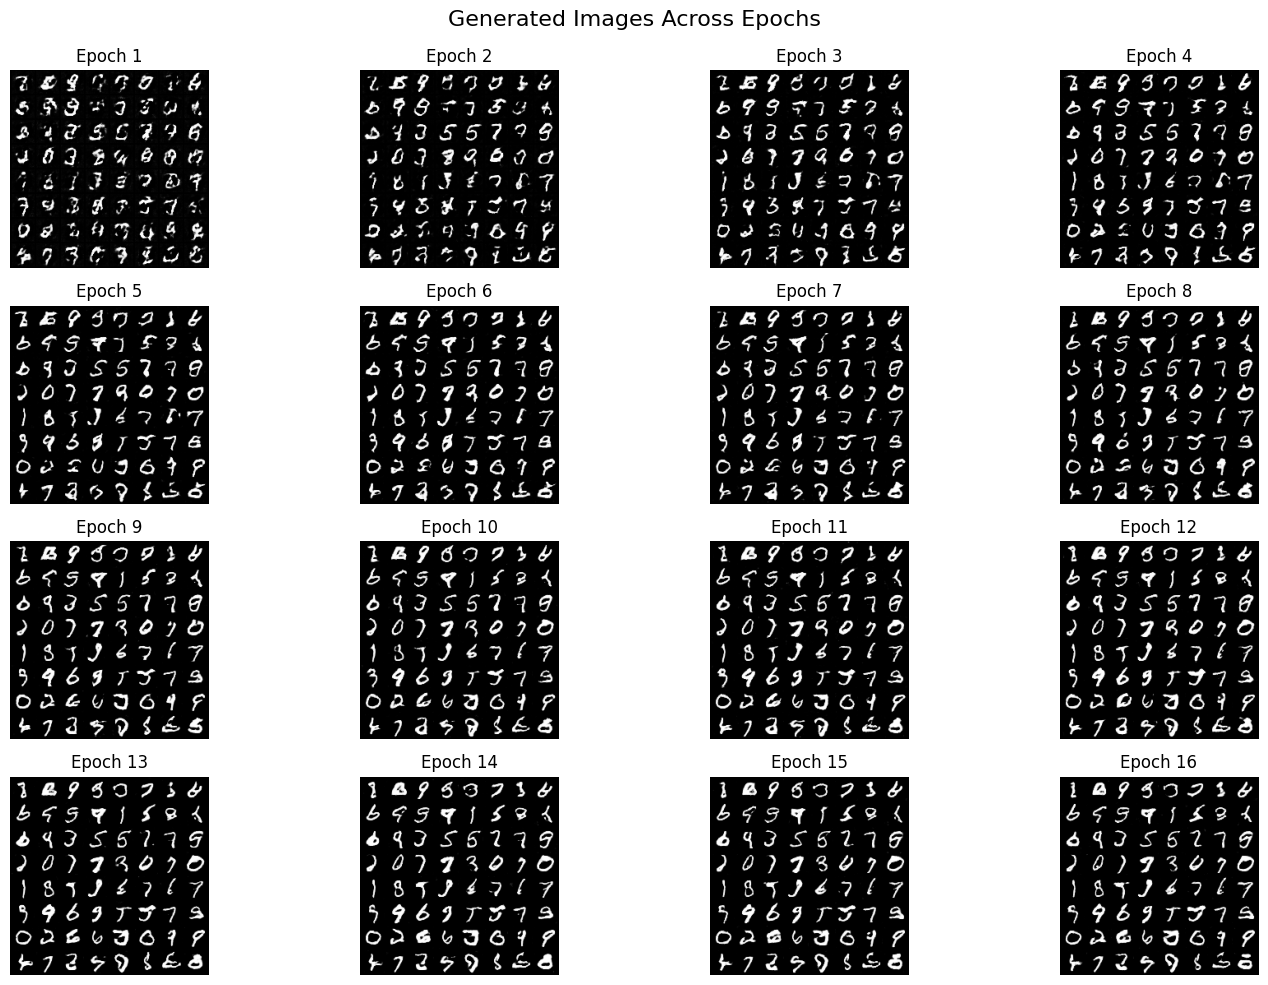

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

# ===================== 1. PARAMETERS =====================
batch_size = 128       # Batch size
latent_dim = 100       # Size of the noise vector
image_size = 28        # MNIST image size
epochs = 16            # Number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

# ===================== 2. LOAD DATA =====================
# Transform: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ===================== 3. MODEL ARCHITECTURES =====================
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ===================== 4. INITIALIZATION =====================
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fixed noise for monitoring progress
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Create a folder to save results
os.makedirs("mnist_gan_results", exist_ok=True)

# ===================== 5. TRAINING GAN =====================
# List to store generated images at each epoch
generated_images = []

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        # Prepare real and fake labels
        real_imgs = real_imgs.to(device)
        real_labels = torch.full((real_imgs.size(0), 1), 0.9, device=device)  # Label smoothing
        fake_labels = torch.zeros(real_imgs.size(0), 1, device=device)

        # === Train the Discriminator ===
        optimizer_D.zero_grad()
        noise = torch.randn(real_imgs.size(0), latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)

        # Loss for real and fake images
        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # === Train the Generator ===
        optimizer_G.zero_grad()
        fake_labels.fill_(1)
        g_loss = criterion(discriminator(fake_imgs), fake_labels)
        g_loss.backward()
        optimizer_G.step()

    # Print losses for monitoring
    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate and save images for this epoch
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).detach().cpu()
        generated_images.append(fake_imgs)  # Store for visualization

print("Training complete!")

# ===================== 6. VISUALIZATION =====================
# Combine generated images into a grid with labels for each epoch
fig, axes = plt.subplots(4, 4, figsize=(15, 10))  # 4x4 grid for 16 epochs
fig.suptitle("Generated Images Across Epochs", fontsize=16)

for i, ax in enumerate(axes.flat):
    img_grid = vutils.make_grid(generated_images[i], nrow=8, normalize=True)
    ax.imshow(img_grid.permute(1, 2, 0))  # Convert to HWC format
    ax.axis("off")
    ax.set_title(f"Epoch {i+1}")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


1. Results Analysis
Image Quality Progression:

Epochs 1–4: The generator starts forming basic structures, but the digits are mostly noisy or distorted. The generator struggles to produce realistic outputs at this stage.
Epochs 5–8: Clearer outlines of digits begin to emerge. Some digits resemble handwritten numbers, but there is still noticeable blurriness and irregular shapes.
Epochs 9–12: The quality of the generated images improves significantly. Most digits are recognizable and realistic, although a few still show artifacts or imperfections.
Epochs 13–16: The generator stabilizes, and the digits become sharper and more consistent. However, minor distortions and artifacts persist in some digits.
Loss Behavior:

Discriminator Loss (D Loss): Stabilizes around 0.7–1.1, indicating a good balance between the generator and discriminator.
Generator Loss (G Loss): Decreases gradually in earlier epochs and stabilizes later, showing progress in generating more realistic images.

2. Strengths

The model successfully generates realistic handwritten digits, especially after Epoch 8.
Training remains relatively stable, as indicated by the balance in losses.
The digits produced in the later epochs are clear and recognizable, meeting the basic goal of the GAN.

3. Suggestions for Improvement

Increase Training Epochs:

Extending the training to 30–50 epochs can allow the generator to refine the digit quality further and reduce artifacts.
Regularization Techniques:

Add Dropout layers to the discriminator to prevent overfitting.
Introduce noise to the discriminator’s input to reduce its confidence and stabilize learning.
Enhance the Architecture:

Use deeper architectures for both the generator and discriminator.
Incorporate Residual Connections to improve image quality and training stability.